# IMAGINE tutorial 1 

## The basic elements of an IMAGINE pipeline

#### ...imagine using a toy model for the field...
#### ...and a corresponding toy simulator...

In this tutorial, we focus on introducing the basic building blocks in IMAGINE package and how to use them for assembling a Bayesian analysis pipeline

We will use mock data with only two independent free parameters. First we need to generate the mock data. Then we will assemble all elements needed for the IMAGINE pipeline, execute the pipeline and investigate its results.


The mock data are designed to naively mimic Faraday depth, which is affected linearly by (Galactic) magnetic field and thermal electron density. As a function of position $x$, we define a constant coherent magnetic field component $a_0$ and a random magnetic field component which is drawn from a Gaussian distribution with standard deviation $b_0$. The electron density is given by a $\cos(x)$ with arbitrary scaling. The mock data values we get are related to the Faraday depth of a background source at some arbitrary distance: 


$ signal(x) = \left[1+\cos(x)\right] \times \mathcal{G}(\mu=a_0,\sigma=b_0;seed=s)\,{\mu\rm G\,cm}^{-3} , \; x \in [0,2\pi\,\rm kpc]$

where $\{a_0,b_0\}$ is the 'physical' parameter set, and $s$ represents the seed for random variable generation.



The purpose is not to fit the exact signal, since it includes a stochastic component, but to fit the amplitude of the signal and of the variations around it.  So this is fitting the strength of the coherent field $a_0$ and the amplitude of the random field $b_0$. 

With mock data and its (co)variance matrix, we shall assemble the IMAGINE pipeline, execute it and examine its results. 

First, import the necessary packages.

In [1]:
import numpy as np
import logging as log
from astropy.table import Table
from astropy import units as u
## visualize posterior with 3rd party corner package (pip install corner)
import corner
import matplotlib.pyplot as plt

import imagine as img

# call after importing matplotlib
%matplotlib inline

## 1) Preparation of mock data

In calculating the mock data values, we introduce noise as:

$ data(x) = signal(x) + noise(x) $

For simplicity, we propose a simple gaussian noise with mean zero and a standard deviation $e$:

$ noise(x) = \mathcal{G}(\mu=0,\sigma=e) $ .

We will assume that we have 10 points in the x-direction, in the range $(0, 2\pi)$.

In [2]:
a0 = 3. # true value of a
b0 = 6. # true value of b
e = 0.1 # std of gaussian measurement error
s = 233 # seed fixed for signal field

size = 10 # data size in measurements
x = np.linspace(0.01,2.*np.pi-0.01,size) # where the observer is looking at

np.random.seed(s) # set seed for signal field

signal = (1+np.cos(x)) * np.random.normal(loc=a0,scale=b0,size=size)

fd = signal + np.random.normal(loc=0.,scale=e,size=size)


data = Table({'meas' : fd, 
              'err': np.ones_like(fd)*e,
              'x': x,
              'y': np.zeros_like(fd),
              'z': np.zeros_like(fd),
              'other': np.ones_like(fd)*42
              })
data[:4] # Shows the first 4 points in tabular form

meas,err,x,y,z,other
float64,float64,float64,float64,float64,float64
16.4217790817552,0.1,0.01,0.0,0.0,42.0
7.172468731201507,0.1,0.7059094785755097,0.0,0.0,42.0
-3.2254947821460433,0.1,1.4018189571510193,0.0,0.0,42.0
0.27949334758966465,0.1,2.0977284357265287,0.0,0.0,42.0


These data need to be converted to an IMAGINE compatible format. To do this, we first create `TabularDataset` object.

In [3]:
import astropy.units as u
fd_units = u.microgauss*u.cm**-3

mockDataset = img.dataset.TabularDataset(data, name='test', 
                                         data_column='meas', 
                                         coordinates_type='cartesian',
                                         x_column='x', y_column='y', 
                                         z_column='z', error_column='err',
                                         units=fd_units)

This simply explains to imagine how to read the tabular dataset (note that the 'other' column is ignored). 
The units of the dataset are represented using [astropy.units](https://docs.astropy.org/en/stable/units/) objects.
Coordinates can be either `cartesian` as in this example, which requires specifying columns for $x$, $y$ and $z$ in $\rm kpc$, or  `galactic`, which requires setting the arguments `lat_column` and `lon_column` both in degrees.

The dataset can be loaded onto `Measurements` and `Covariances` object, which are subclasses of `ObservableDict`. These objects allow one to supply multiple datasets to the pipeline.

In [4]:
mock_data = img.Measurements() # create empty Measrurements object
mock_data.append(dataset=mockDataset)

mock_cov = img.Covariances() # create empty Covariance object
mock_cov.append(dataset=mockDataset)

The dataset object creates a standard key for each appended dataset. In our case, there is only one key.

In [5]:
keys = list(mock_data.keys())
keys

[('test', 'nan', 'tab', 'nan')]

Let us plot the mock data as well as the $\cos(x)$ function that is the underlying variation.  

The property `Measurements.global_data` extracts arrays from the `Observable` object which is hosted inside the `ObservableDict` class. 

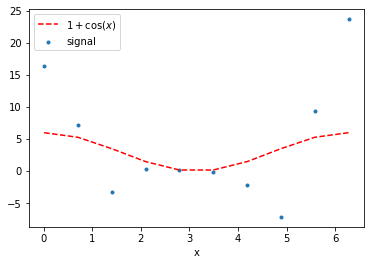

In [6]:
plt.scatter(x, mock_data[keys[0]].global_data[0], marker='.', label='signal')
plt.plot(x,(1+np.cos(x))*a0,'r--',label='$1+\cos(x)$')
plt.xlabel('x'); plt.legend();

Note that the variance in the signal is highest where the $\cos(x)$ is also strongest. This is the way we expect the Faraday depth to work, since a fluctuation in the strength of $\mathbf B$ has a larger effect on the RM when $n_e$ also happens to be higher. 

## 2) Pipeline assembly

Now that we have generated mock data, there are several steps to set up the pipeline to estimate the input parameters.  We need to define field models, simulators, likelihoods and priors.

1) Coordinate grid: the coordinate grid on which the fields will be evaluated

In [7]:
one_d_grid = img.UniformGrid(box=[[0,2*np.pi]*u.kpc,
                                 [0,0.001]*u.kpc,
                                 [0,0.001]*u.kpc],
                             resolution=[30,2,2])

2) Field models: in this test we will use two field models: one for the thermal electrons, and another one for the magneticfield.

`CosThermalElectronDensity` corresponds to a toy model for electron density with the form: $n_e(x,y,z) = n_0 [1+\cos (a x + \alpha)][1+\cos (b y + \beta)][1+\cos(c y + \gamma)]$. We include this in the pipeline instantiating and adjusting the associated *Field Factory*:

In [8]:
import imagine.fields.test_field as testFields
ne_factory = testFields.CosThermalElectronDensity_Factory(grid=one_d_grid)

We can set and check the default parameter values in the following way:

In [9]:
ne_factory.default_parameters= {'a': 1*u.rad/u.kpc,
                                'beta':  np.pi/2*u.rad, 
                                'gamma': np.pi/2*u.rad}
ne_factory.default_parameters

{'n0': <Quantity 1. 1 / cm3>,
 'a': <Quantity 1. rad / kpc>,
 'b': <Quantity 0. rad / kpc>,
 'c': <Quantity 0. rad / kpc>,
 'alpha': <Quantity 0. rad>,
 'beta': <Quantity 1.57079633 rad>,
 'gamma': <Quantity 1.57079633 rad>}

We will now similarly define the magnetic field, using the `NaiveGaussianMagneticField` which constructs a "naive" random field (i.e. the magnitude of $x$, $y$ and $z$ components of the field are drawn from a Gaussian distribution **without** imposing *zero divergence*, thus *do not use this for serious applications*). 

In [10]:
B_factory = testFields.NaiveGaussianMagneticField_Factory(grid=one_d_grid)
B_factory.active_parameters = ('a0','b0')
B_factory.priors ={'a0': img.FlatPrior(interval=[-10,10]*u.microgauss),
                   'b0': img.FlatPrior(interval=[0,10]*u.microgauss)}
B_factory.default_parameters = {'a0':a0*u.microgauss, 'b0':b0*u.microgauss}

In [11]:
factory_list = [ne_factory, B_factory]

3) Simulators: For this tutorial, we use a customized TestSimulator which simply computes the quantity: $t(x,y,z) = B_y\,n_e\,$,i.e. the contribution at one specific point to the Faraday depth.

The simulator is inialized with the mock Measurements defined before, which allows it to know what is the correct format for output.

In [12]:
from imagine.simulators.test_simulator import TestSimulator
simer = TestSimulator(mock_data)

In [13]:
B = B_factory.generate(ensemble_size=100)

In [14]:
ne = ne_factory.generate(ensemble_size=100)

4) Likelihoods: IMAGINE provides the `Likelihood` class with `EnsembleLikelihood` and `SimpleLikelihood` as two options.  The `SimpleLikelihood` is what you expect, computing a single $\chi^2$ from the difference of the simulated and the measured datasets.  The `EnsembleLikelihood` is how IMAGINE handles a signal which itself includes a stochastic component, e.g., what we call the Galactic variance.  This likelihood module makes use of a finite ensemble of simulated realizations and uses their mean and covariance to compare them to the measured dataset.  

In [15]:
likelihood = img.EnsembleLikelihood(mock_data, mock_cov) # initialize likelihood with measured info

Now we are ready to construct and run the pipeline itself.

As you will see below, the `Pipeline` class takes as input arguments all elements we defined in the lines above to start calculating.

The current two pipelines here are based on different samplers:

1. `MultinestPipeline` : is quite old but fast, has its core in Fortran.
2. `DynestyPipeline`: is new and purely in Python, extremely well documented, but it's slower

Since we are using the `EnsembleLikelihood`, we also need to define an ensemble size, i.e. the number of simulations with the same input parameters that will be generated at each sample. Different realizations of the random magnetic field will render all simulated data sets different; their variance is an estimate of the Galactic variance.

In [16]:
## Generate 100 realizations at each sample
ensemble_size = 10  
## Define the pipeline using the MultiNest sampler, giving it the required elements
pipe = img.MultinestPipeline(simer, factory_list, likelihood, ensemble_size)
## Set its random seed with a positive integer, or 0 to start randomly from the system clock.  
pipe.random_type = 'free'
## Set some controller parameters that are specific to pyMultiNest.  
pipe.sampling_controllers = {'n_iter_before_update': 1,
                             'n_live_points': 200,
                             'verbose': True,
                             'resume': False}

## 3a) Pipeline roll out with Multinest

The IMAGINE pipeline use variables which all range within $[0,1]$ internally. This conversion from physical parameters (with arbitrary extrema) and parameters (in range $[0,1]$) is done automatically in the factories. The function `unity_mapper` reads the information in the samples and then then maps the output parameters back to their physical values.

This actually runs the pipeline and will take a few seconds:

In [17]:
results = pipe()

  analysing data from chains/imagine_.txt


Now we can look at the results, which consist of a set of sampled points in the likelihood space.  

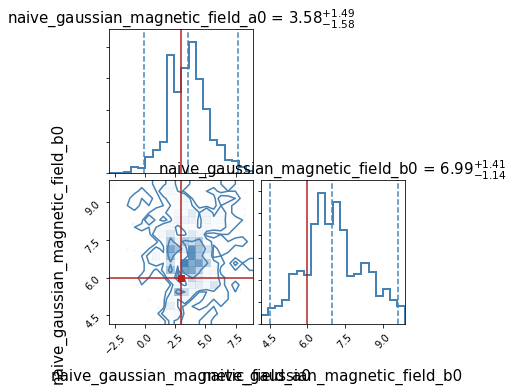

In [18]:
from imagine.tools.carrier_mapper import unity_mapper
samples = results['samples']  # load sample points

## convert from pipeline-internal (0-1) values into physical parameters
for i, param in enumerate(pipe.active_parameters): 
    low, high = pipe.active_ranges[param]
    for j, sample in enumerate(samples[:,i]):
        samples[j,i] = unity_mapper(sample, low, high)

##  See https://corner.readthedocs.io/en/latest/pages/sigmas.html about contour levels.  
##  "Contours are shown at 0.5, 1, 1.5, and 2 sigma" by default
##  according to https://pypi.org/project/corner/1.0.1/, but I want 1, 2, and 3.
sigmas=np.array([1.,2.,3.])
levels=1-np.exp(-0.5*sigmas*sigmas)

# Visualize with a corner plot
figure = corner.corner(samples[:, :len(pipe.active_parameters)],
                      range=[0.99]*len(pipe.active_parameters),
                      quantiles=[0.02, 0.5, 0.98],
                      labels=pipe.active_parameters,
                      show_titles=True,
                      title_kwargs={"fontsize": 15},
                      color='steelblue',
                      truths=[a0,b0],
                      truth_color='firebrick',
                      plot_contours=True,
                      hist_kwargs={'linewidth': 2},
                      label_kwargs={'fontsize': 15},
                      levels=levels)

## 3b) Pipeline roll out with a Dynesty

Now, use the Dynesty sampler instead of MultiNest.
The only difference at the frontend is the sampler-dependent
controlling parameters. 
One advantage of Dynesty is that it provides an informative 
progress bar under the cell executing it, as you can see.

(This run takes a bit longer, tens of seconds, likely because
the sampler needs to be optimized better.)  

In [ ]:
from imagine.pipelines.dynesty_pipeline import DynestyPipeline

pipe_dynesty = DynestyPipeline(simer, factory_list, likelihood, ensemble_size)
pipe_dynesty.random_type = 'free'
pipe_dynesty.sampling_controllers = {'dlogz':'0.1'} 

results_dynesty = pipe_dynesty(maxbatch=2, maxiter=700)

In [ ]:
import dynesty as dyn
import dynesty.plotting as dynplot
# dyn.plotting.
weights = np.exp(pipe_dynesty.sampler.results['logwt'] - 
                 pipe_dynesty.sampler.results['logz'][-1])
plt.hist(pipe_dynesty.sampler.results['samples'][:,0], weights=weights, bins=15)

plt.hist(pipe_dynesty.sampler.results['samples'][:,1], weights=weights, bins=15);

In [ ]:
# results_dynesty = pipe_dynesty(maxiter=1000)
samples = results_dynesty['samples']
for i, param in enumerate(pipe_dynesty.active_parameters): 
    low, high = pipe_dynesty.active_ranges[param]
    for j, sample in enumerate(samples[:,i]):
        samples[j, i] = unity_mapper(sample, low, high)
# corner plot
figure = corner.corner(samples[:, :len(pipe_dynesty.active_parameters)],
                       range=[0.99]*len(pipe_dynesty.active_parameters),
                       quantiles=[0.02, 0.5, 0.98],
                       labels=pipe_dynesty.active_parameters,
                       show_titles=True,
                       title_kwargs={"fontsize": 15},
                       color='steelblue',
                       truths=[a0,b0],
                       truth_color='firebrick',
                       plot_contours=True,
                       hist_kwargs={'linewidth': 2},
                       label_kwargs={'fontsize': 15})

## Addendum: a simple convergence check

The mock data was generated with a fixed random seed, while in the Bayesian analysis time-thread dependent seeds are adopted. Therefore, it is interesting to check if different executions are consistent.  In other words, when you start the sampler at different places, does it always converge on the same region of parameter space?  Let's see what happens when we run it five times and just overplot histograms of the outputs to see if they all look the same.  There are more rigorous tests, of course, that we have done, but they take longer.  This can be done in a few minutes:

In [ ]:
from scipy.stats import norm
repeat = 5

for i in range(repeat):
    tmp = pipe()
    asamp = tmp['samples'][:,0]
    bsamp = tmp['samples'][:,1]
    plt.hist(asamp, 30, histtype='step', stacked=True, 
             fill=True, color='firebrick', alpha=0.1)
    plt.hist(bsamp, 30, histtype='step', stacked=True,
             fill=True,label='b',color='steelblue',alpha=0.1)

### This ends tutorial 1. 

The python script for tutorial 1 can be found in [li_multinest](https://github.com/IMAGINE-Consortium/imagine/blob/mpi/examples/test_examples/lisimulator_multinest.py) and [li_dynesty](https://github.com/IMAGINE-Consortium/imagine/blob/mpi/examples/test_examples/lisimulator_dynesty.py)
